
# Metrics

## Data

### Close value

In [1]:
import sys

sys.path.append('..')
from timeseries.timeseries import StockMarketSeries
from timeseries.utils import SeriesColumn
from metrics.utils import MetricLevel, DefectsSource
from metrics.utils import DefectsScale

time_series_start = 0
time_series_end = 300
stock = StockMarketSeries("Adobe", "../data/adobe.csv", time_series_start, time_series_end,
                          all_noises_strength={DefectsScale.SLIGHTLY: 0.7,
                                               DefectsScale.MODERATELY: 3.0,
                                               DefectsScale.HIGHLY: 7.0},
                          all_incomplete_parts={DefectsScale.SLIGHTLY: 0.05,
                                                DefectsScale.MODERATELY: 0.12,
                                                DefectsScale.HIGHLY: 0.3},
                          partially_noised_strength={SeriesColumn.CLOSE: {DefectsScale.SLIGHTLY: 0.6,
                                                                          DefectsScale.MODERATELY: 2.0,
                                                                          DefectsScale.HIGHLY: 6.0},
                                                     SeriesColumn.OPEN: {DefectsScale.SLIGHTLY: 0.4,
                                                                         DefectsScale.MODERATELY: 1.7,
                                                                         DefectsScale.HIGHLY: 5.2}},
                          partially_incomplete_parts={SeriesColumn.CLOSE: {DefectsScale.SLIGHTLY: 0.05,
                                                                           DefectsScale.MODERATELY: 0.12,
                                                                           DefectsScale.HIGHLY: 0.3},
                                                      SeriesColumn.OPEN: {DefectsScale.SLIGHTLY: 0.05,
                                                                          DefectsScale.MODERATELY: 0.12,
                                                                          DefectsScale.HIGHLY: 0.3}})

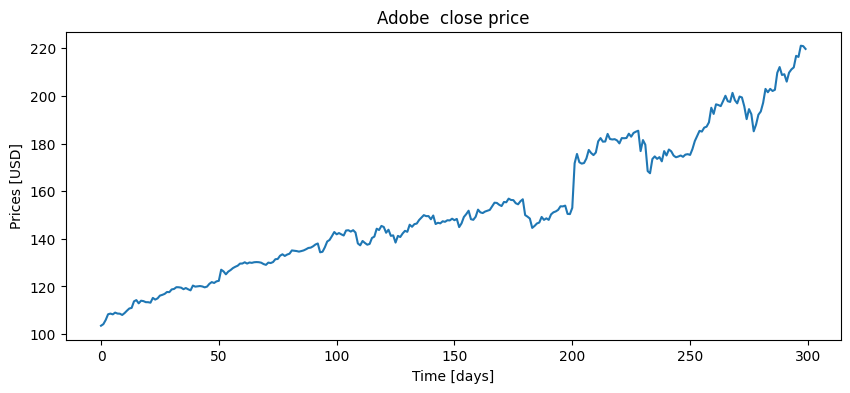

In [2]:
stock.plot_single_series(stock.real_series[SeriesColumn.CLOSE], SeriesColumn.CLOSE)

### Other values

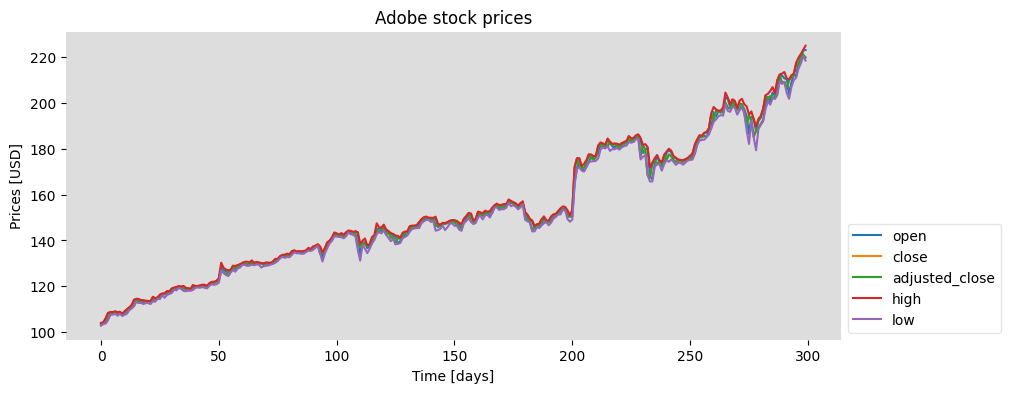

In [3]:
stock.plot_multiple_series("stock prices",
                           open=stock.real_series[SeriesColumn.OPEN],
                           close=stock.real_series[SeriesColumn.CLOSE],
                           adjusted_close=stock.real_series[SeriesColumn.ADJ_CLOSE],
                           high=stock.real_series[SeriesColumn.HIGH],
                           low=stock.real_series[SeriesColumn.LOW])

## Correctness metric

### Show noise

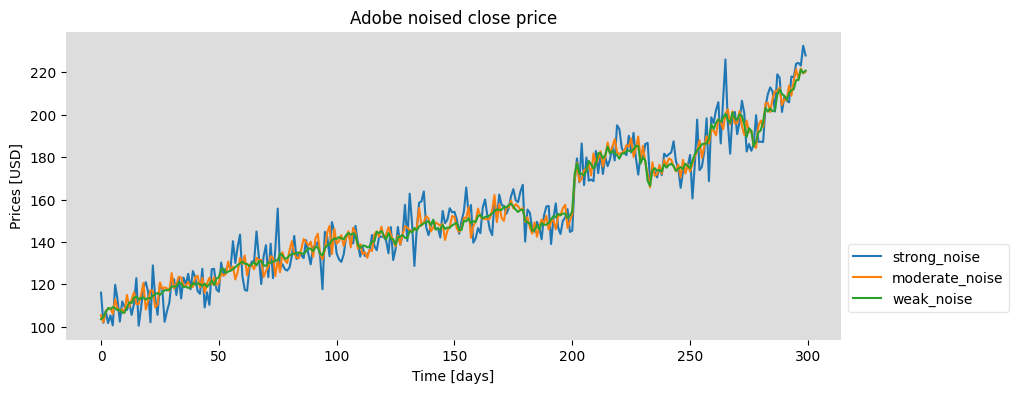

In [4]:
stock.plot_multiple_series("noised close price",
                           strong_noise=stock.all_defected_series[DefectsSource.NOISE][DefectsScale.HIGHLY][
                               SeriesColumn.CLOSE],
                           moderate_noise=stock.all_defected_series[DefectsSource.NOISE][DefectsScale.MODERATELY][
                               SeriesColumn.CLOSE],
                           weak_noise=stock.all_defected_series[DefectsSource.NOISE][DefectsScale.SLIGHTLY][
                               SeriesColumn.CLOSE])

### Heinrich's correctness metric on values

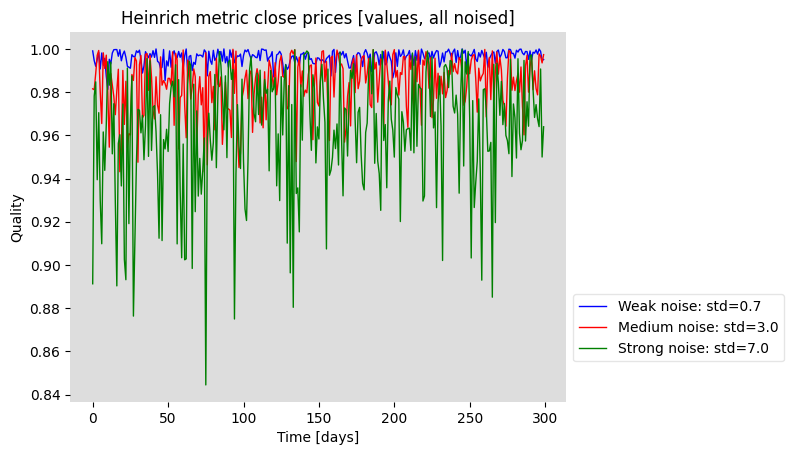

In [5]:
from correctness import HeinrichCorrectnessMetric
from metrics.utils import DefectionRange

heinrich = HeinrichCorrectnessMetric(stock,
                                     alpha={SeriesColumn.OPEN: 1.6,
                                            SeriesColumn.CLOSE: 2.1,
                                            SeriesColumn.ADJ_CLOSE: 1.7,
                                            SeriesColumn.HIGH: 2.0,
                                            SeriesColumn.LOW: 2.3,
                                            SeriesColumn.VOLUME: 3.1})

weak, moderate, strong = heinrich.values_qualities(SeriesColumn.CLOSE, is_alpha=False)
heinrich.draw_heinrich_qualities(weak, moderate, strong, MetricLevel.VALUES, is_alpha=False,
                                 column_name=SeriesColumn.CLOSE)

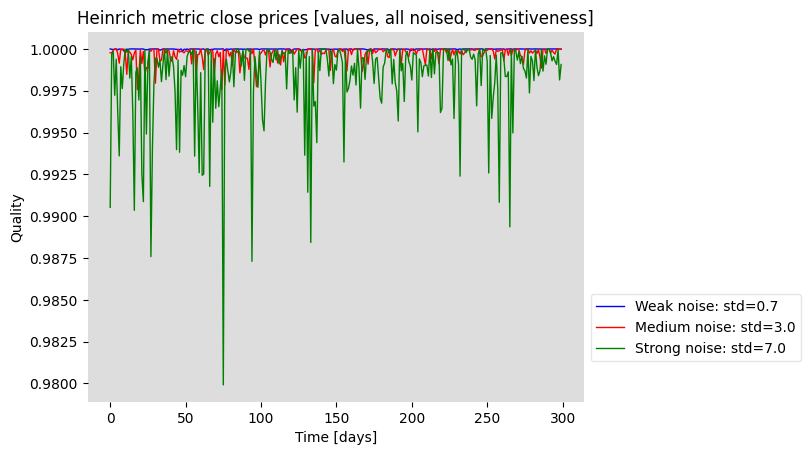

In [6]:
sensitive, medium, insensitive = heinrich.values_qualities(SeriesColumn.CLOSE, is_alpha=True)
heinrich.draw_heinrich_qualities(sensitive, medium, insensitive, MetricLevel.VALUES, is_alpha=True,
                                 column_name=SeriesColumn.CLOSE)

### Heinrich's correctness metric on tuples - all fields noised

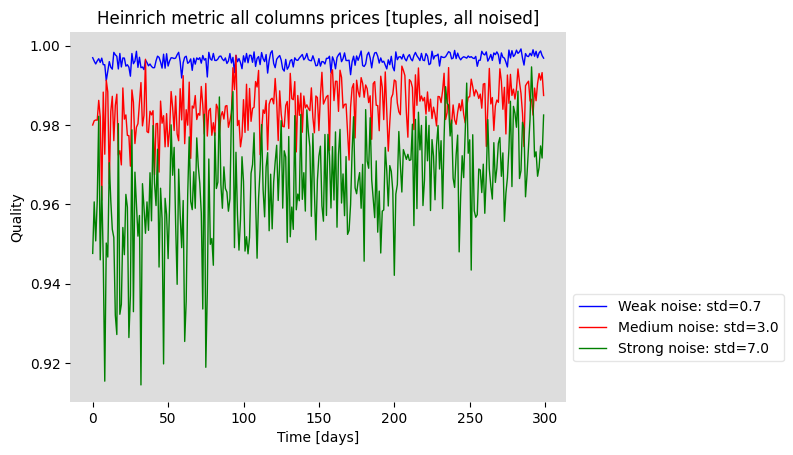

In [7]:
adobe_tuple_weights = [0.2, 0.2, 0.25, 0.15, 0.15, 0.05]

weak, moderate, strong = heinrich.tuples_qualities(adobe_tuple_weights, noised_series=DefectionRange.ALL,
                                                   is_alpha=False)
heinrich.draw_heinrich_qualities(weak, moderate, strong,
                                 MetricLevel.TUPLES, is_alpha=False, noise_range=DefectionRange.ALL)

### Heinrich's correctness metric on tuples - some fields noised

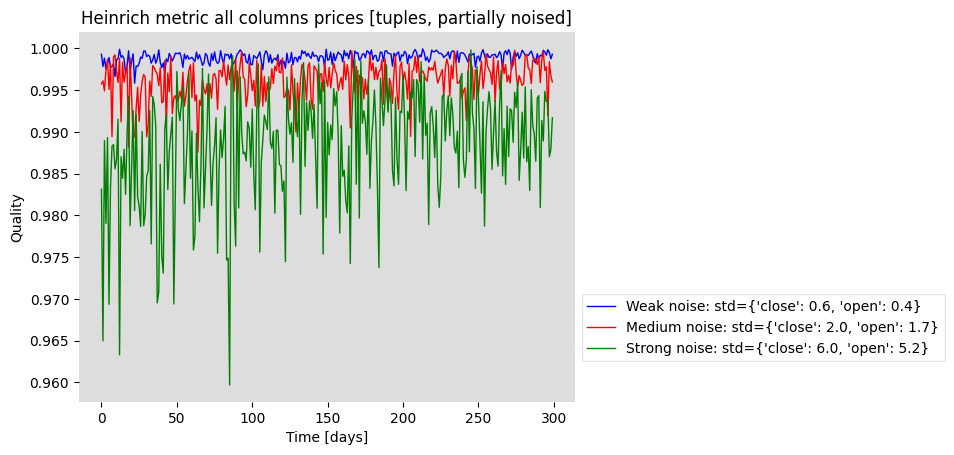

In [8]:
weak, moderate, strong = heinrich.tuples_qualities(adobe_tuple_weights, noised_series=DefectionRange.PARTIAL,
                                                   is_alpha=False)
heinrich.draw_heinrich_qualities(weak, moderate, strong,
                                 MetricLevel.TUPLES, is_alpha=False, noise_range=DefectionRange.PARTIAL)

### Heinrich's correctness metric on relation

In [9]:
weak_noise, moderate_noise, strong_noise = heinrich.relation_qualities(adobe_tuple_weights, is_alpha=False)

print("Relation quality differences due to different noise levels of all fields")
print(f"Quality (weak noise): {weak_noise}")
print(f"Quality (moderate noise): {moderate_noise}")
print(f"Quality (strong noise): {strong_noise}")

Relation quality differences due to different noise levels of all fields
Quality (weak noise): 0.9965373344011325
Quality (moderate noise): 0.9845656686119416
Quality (strong noise): 0.9645353570213974


In [10]:
weak_noise, moderate_noise, strong_noise = heinrich.relation_qualities(adobe_tuple_weights,
                                                                       noised_series=DefectionRange.PARTIAL,
                                                                       is_alpha=False)

print("Relation quality differences due to different noise levels of some fields")
print(f"Quality (weak noise): {weak_noise}")
print(f"Quality (moderate noise): {moderate_noise}")
print(f"Quality (strong noise): {strong_noise}")

Relation quality differences due to different noise levels of some fields
Quality (weak noise): 0.9989442291069628
Quality (moderate noise): 0.9961146490353627
Quality (strong noise): 0.9883984719027528


## Completeness metrics

### Show incompleteness

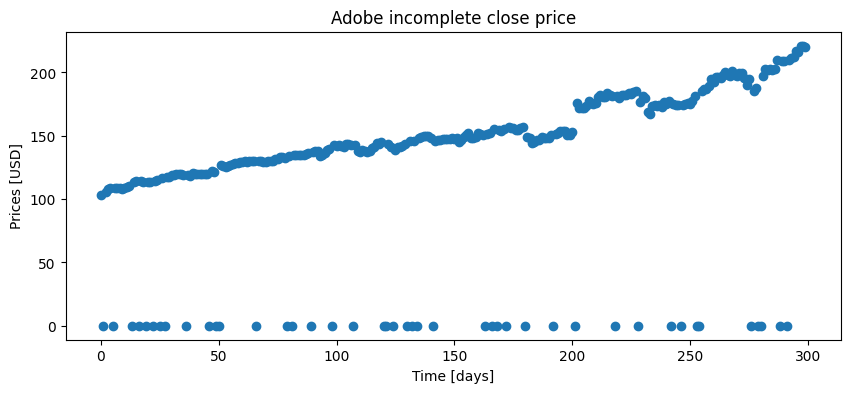

In [11]:
adobe_close_incomplete = stock.all_defected_series[DefectsSource.INCOMPLETENESS][DefectsScale.MODERATELY][
    SeriesColumn.CLOSE]
stock.plot_single_series(adobe_close_incomplete, SeriesColumn.CLOSE, defection="incomplete", plot_type="o")

### Blake's completeness metric on values

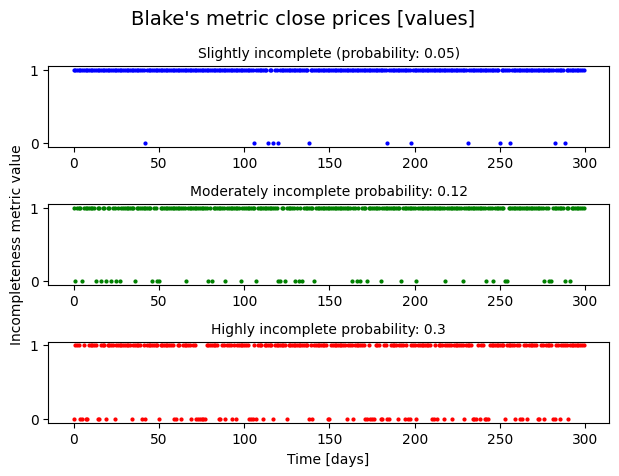

In [12]:
from metrics.completeness import BlakeCompletenessMetric

blake = BlakeCompletenessMetric(stock)
qualities_first, qualities_second, qualities_third = blake.values_qualities(SeriesColumn.CLOSE)
blake.draw_blake(qualities_first, qualities_second, qualities_third, MetricLevel.VALUES, column_name=SeriesColumn.CLOSE)

### Blake's completeness metric on tuples - all columns affected

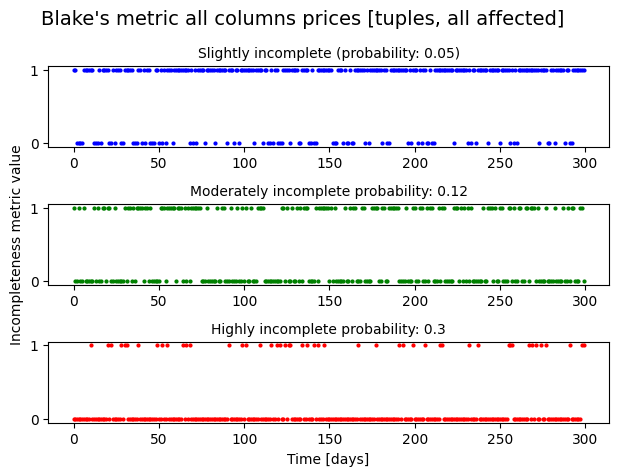

In [13]:
qualities_first, qualities_second, qualities_third = blake.tuples_qualities(incompleteness_range=DefectionRange.ALL)
blake.draw_blake(qualities_first, qualities_second, qualities_third, MetricLevel.TUPLES,
                 incompleteness_range=DefectionRange.ALL)

### Blake's completeness metric on tuples - some columns affected

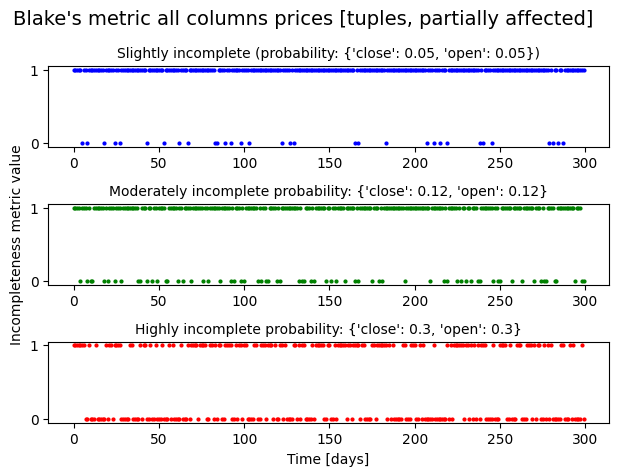

In [14]:
qualities_first, qualities_second, qualities_third = blake.tuples_qualities(incompleteness_range=DefectionRange.PARTIAL)
blake.draw_blake(qualities_first, qualities_second, qualities_third, MetricLevel.TUPLES,
                 incompleteness_range=DefectionRange.PARTIAL)

### Blake's completeness metric on relation

In [15]:
qualities_first, qualities_second, qualities_third = blake.relation_qualities(incompleteness_range=DefectionRange.ALL)

print("Quality differences due to different incompleteness of all columns")
print(f"Blake's slightly incomplete data quality: {qualities_first}")
print(f"Blake's moderately incomplete data quality: {qualities_second}")
print(f"Blake's highly incomplete data quality: {qualities_third}")

Quality differences due to different incompleteness of all columns
Blake's slightly incomplete data quality: 0.7166666666666667
Blake's moderately incomplete data quality: 0.44333333333333336
Blake's highly incomplete data quality: 0.16333333333333333


In [16]:
qualities_first, qualities_second, qualities_third = blake.relation_qualities(
    incompleteness_range=DefectionRange.PARTIAL)

print("Quality differences due to different incompleteness levels of some columns")
print(f"Blake's slightly incomplete data quality: {qualities_first}")
print(f"Blake's moderately incomplete data quality: {qualities_second}")
print(f"Blake's highly incomplete data quality: {qualities_third}")

Quality differences due to different incompleteness levels of some columns
Blake's slightly incomplete data quality: 0.8933333333333333
Blake's moderately incomplete data quality: 0.77
Blake's highly incomplete data quality: 0.4866666666666667
